In [351]:
# import libraries
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from keras.models import Sequential
from keras.layers import *
from keras.optimizers import SGD, Adam
from keras.utils import np_utils
import numpy as np
from keras import backend as K
%matplotlib inline

In [2]:
# On some implementations of matplotlib, you may need to change this value
IMAGE_SIZE = 72

def generate_a_drawing(figsize, U, V, noise=0.0):
    fig = plt.figure(figsize=(figsize,figsize))
    ax = plt.subplot(111)
    plt.axis('Off')
    ax.set_xlim(0,figsize)
    ax.set_ylim(0,figsize)
    ax.fill(U, V, "k")
    fig.canvas.draw()
    imdata = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)[::3].astype(np.float32)
    imdata = imdata + noise * np.random.random(imdata.size)
    plt.close(fig)
    return imdata

def generate_a_rectangle(noise=0.0, free_location=False):
    figsize = 1.0    
    U = np.zeros(4)
    V = np.zeros(4)
    if free_location:
        corners = np.random.random(4)
        top = max(corners[0], corners[1])
        bottom = min(corners[0], corners[1])
        left = min(corners[2], corners[3])
        right = max(corners[2], corners[3])
    else:
        side = (0.3 + 0.7 * np.random.random()) * figsize
        top = figsize/2 + side/2
        bottom = figsize/2 - side/2
        left = bottom
        right = top
    U[0] = U[1] = top
    U[2] = U[3] = bottom
    V[0] = V[3] = left
    V[1] = V[2] = right
    return generate_a_drawing(figsize, U, V, noise)


def generate_a_disk(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        center = np.random.random(2)
    else:
        center = (figsize/2, figsize/2)
    radius = (0.3 + 0.7 * np.random.random()) * figsize/2
    N = 50
    U = np.zeros(N)
    V = np.zeros(N)
    i = 0
    for t in np.linspace(0, 2*np.pi, N):
        U[i] = center[0] + np.cos(t) * radius
        V[i] = center[1] + np.sin(t) * radius
        i = i + 1
    return generate_a_drawing(figsize, U, V, noise)

def generate_a_triangle(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        U = np.random.random(3)
        V = np.random.random(3)
    else:
        size = (0.3 + 0.7 * np.random.random())*figsize/2
        middle = figsize/2
        U = (middle, middle+size, middle-size)
        V = (middle+size, middle-size, middle-size)
    imdata = generate_a_drawing(figsize, U, V, noise)
    return [imdata, [U[0], V[0], U[1], V[1], U[2], V[2]]]

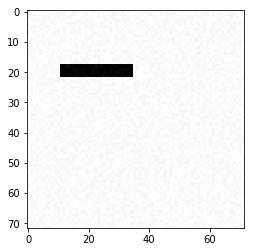

In [3]:
im = generate_a_rectangle(10, True)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

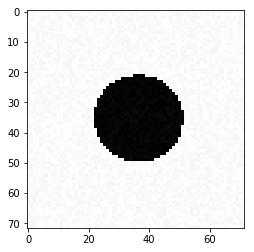

In [4]:
im = generate_a_disk(10)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

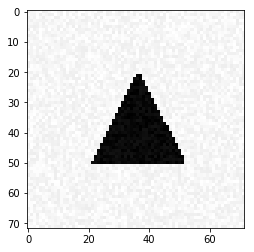

In [5]:
[im, v] = generate_a_triangle(20, False)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

In [335]:
def generate_dataset_denoising(nb_samples, amplitude_max=100,free_location=False):
    # Getting im_size:
    im_size = generate_a_rectangle().shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros([nb_samples,im_size])
    noises = np.random.randint(amplitude_max, size=nb_samples)
    for i in range(nb_samples):
        category = np.random.randint(3)
        if category == 0:
            Y[i] = generate_a_rectangle(0.0, free_location)
            X[i] = Y[i] + noises[i] * np.random.random(Y[i].size)
        elif category == 1: 
            Y[i] = generate_a_disk(0.0, free_location)
            X[i] = Y[i] + noises[i] * np.random.random(Y[i].size)
        else:
            [Y[i], V] = generate_a_triangle(0.0, free_location)
            X[i] = Y[i] + noises[i] * np.random.random(Y[i].size)
    X = (X + amplitude_max) / (255 + 2 * amplitude_max)
    return [X, Y]
def generate_dataset_classification(nb_samples, noise=0.0, free_location=False):
    # Getting im_size:
    im_size = generate_a_rectangle().shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros(nb_samples)
    for i in range(nb_samples):
        category = np.random.randint(3)
        if category == 0:
            X[i] = generate_a_rectangle(noise, free_location)
        elif category == 1: 
            X[i] = generate_a_disk(noise, free_location)
        else:
            [X[i], V] = generate_a_triangle(noise, free_location)
        Y[i] = category
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

def generate_test_set_classification():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_classification(300, 20, True)
    Y_test = np_utils.to_categorical(Y_test, 3) 
    return [X_test, Y_test]


In [160]:
def generate_dataset_regression(nb_samples, noise=0.0):
    # Getting im_size:
    im_size = generate_a_triangle()[0].shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros([nb_samples, 6])
    for i in range(nb_samples):
        [X[i], Y[i]] = generate_a_triangle(noise, True)
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

def visualize_prediction(x, y):
    fig, ax = plt.subplots(figsize=(5, 5))
    I = x.reshape((IMAGE_SIZE,IMAGE_SIZE))
    ax.imshow(I, extent=[-0.15,1.15,-0.15,1.15],cmap='gray')
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])

    xy = y.reshape(3,2)
    tri = patches.Polygon(xy, closed=True, fill = False, edgecolor = 'r', linewidth = 5, alpha = 0.5)
    ax.add_patch(tri)

    plt.show()

def generate_test_set_regression():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_regression(300, 20)
    return [X_test, Y_test]


## Simple Classification :

In [85]:
[X_train, Y_train] = generate_dataset_classification(300, 20) # generate data set 
Y_train = np_utils.to_categorical(Y_train) # convert output to binary

In [86]:
def lin_classifier (optim) :
    model = Sequential() # create model
    model.add(Dense(3, input_shape=(5184,))) # add layers 
    model.add(Activation('softmax')) # add softmax activationas
                                    # functions to have the output as probabilities
    model.compile(loss='categorical_crossentropy',
                  optimizer=optim, metrics=['accuracy']) # define the compiler
    return model

In [87]:
model_sgd = lin_classifier ('sgd')
model_sgd.fit(X_train, Y_train, batch_size=32, epochs=10, verbose=1)

Epoch 1/10
300/300 [==============================] - 1s 3ms/step - loss: 7.6140 - acc: 0.3433
Epoch 2/10
300/300 [==============================] - 0s 84us/step - loss: 8.3805 - acc: 0.3733
Epoch 3/10
300/300 [==============================] - 0s 104us/step - loss: 10.1007 - acc: 0.3733
Epoch 4/10
300/300 [==============================] - 0s 104us/step - loss: 10.1007 - acc: 0.3733
Epoch 5/10
300/300 [==============================] - 0s 110us/step - loss: 10.1007 - acc: 0.3733
Epoch 6/10
300/300 [==============================] - 0s 96us/step - loss: 10.1007 - acc: 0.3733
Epoch 7/10
300/300 [==============================] - 0s 98us/step - loss: 10.1007 - acc: 0.3733
Epoch 8/10
300/300 [==============================] - 0s 99us/step - loss: 10.1007 - acc: 0.3733
Epoch 9/10
300/300 [==============================] - 0s 97us/step - loss: 10.1007 - acc: 0.3733
Epoch 10/10
300/300 [==============================] - 0s 128us/step - loss: 10.1007 - acc: 0.3733


In [88]:
model_adam = lin_classifier ('Adam')
model_adam.fit(X_train, Y_train, batch_size=32, epochs=10, verbose=1)

Epoch 1/10
300/300 [==============================] - 1s 4ms/step - loss: 2.5067 - acc: 0.3967
Epoch 2/10
300/300 [==============================] - 0s 129us/step - loss: 1.0008 - acc: 0.5833
Epoch 3/10
300/300 [==============================] - 0s 85us/step - loss: 0.6584 - acc: 0.7267
Epoch 4/10
300/300 [==============================] - 0s 113us/step - loss: 0.4636 - acc: 0.8300
Epoch 5/10
300/300 [==============================] - 0s 117us/step - loss: 0.3343 - acc: 0.9133
Epoch 6/10
300/300 [==============================] - 0s 111us/step - loss: 0.2775 - acc: 0.9467
Epoch 7/10
300/300 [==============================] - 0s 94us/step - loss: 0.2472 - acc: 0.9133
Epoch 8/10
300/300 [==============================] - 0s 98us/step - loss: 0.2803 - acc: 0.8733
Epoch 9/10
300/300 [==============================] - 0s 127us/step - loss: 0.2993 - acc: 0.8700
Epoch 10/10
300/300 [==============================] - 0s 111us/step - loss: 0.2618 - acc: 0.8933


As expected the Adam optimizer converge very quickly compared to stochastic gradient descent optimizer

we test our model with input as a disk
the model predict a disk


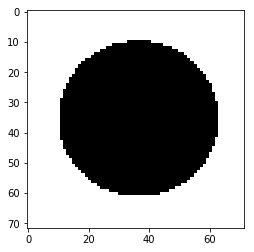

In [94]:
X_test = generate_a_disk()
print('we test our model with input as a disk')
X_test = X_test.reshape(1, X_test.shape[0])
pred = model_adam.predict(X_test)
if pred[0][0] == 1 :
    print('the model predict a rectangle')
elif pred[0][1] == 1 :
    print('the model predict a disk')
else :
    print('the model predict a triangle')
plt.imshow(X_test.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

## Visualization of the Solution :

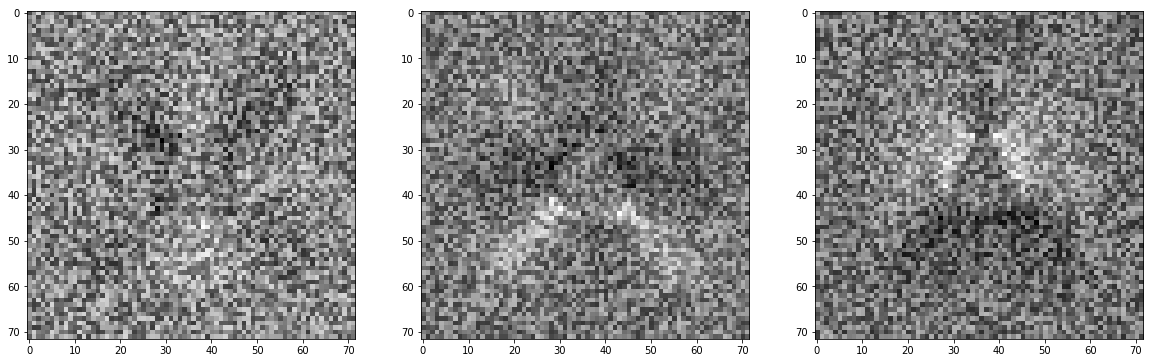

In [109]:
weights =model_adam.get_weights()[0]
fig, size = plt.subplots(figsize=(20,10),)
plt.subplot(131)
plt.imshow(weights.T[0].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
plt.subplot(132)
plt.imshow(weights.T[1].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
plt.subplot(133)
plt.imshow(weights.T[2].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

the output of each layer is the inner product of input image and the corresponding 
weights image, and the softmax of the output is maximum when both input and weights 
have the same gradient.
Then the neuron weights converge to the geometric shape which he should detected

## A More Difficult Classification Problem :

In [150]:
[X_train, Y_train] = generate_dataset_classification(300, 20, True)
Y_train = np_utils.to_categorical(Y_train) 

In [151]:
[X_test, Y_test] = generate_test_set_classification()

In [152]:
model_adam = lin_classifier ('Adam')
model_adam.fit(X_train, Y_train, batch_size=32, epochs=10, verbose=1)

Epoch 1/10
300/300 [==============================] - 2s 6ms/step - loss: 2.5729 - acc: 0.3633
Epoch 2/10
300/300 [==============================] - 0s 108us/step - loss: 1.4375 - acc: 0.4000
Epoch 3/10
300/300 [==============================] - 0s 107us/step - loss: 1.1793 - acc: 0.4133
Epoch 4/10
300/300 [==============================] - 0s 120us/step - loss: 1.1674 - acc: 0.4600
Epoch 5/10
300/300 [==============================] - 0s 106us/step - loss: 1.0438 - acc: 0.5200
Epoch 6/10
300/300 [==============================] - 0s 117us/step - loss: 0.8827 - acc: 0.5900
Epoch 7/10
300/300 [==============================] - 0s 109us/step - loss: 0.8114 - acc: 0.6333
Epoch 8/10
300/300 [==============================] - 0s 122us/step - loss: 0.7698 - acc: 0.6133
Epoch 9/10
300/300 [==============================] - 0s 120us/step - loss: 0.7791 - acc: 0.6367
Epoch 10/10
300/300 [==============================] - 0s 98us/step - loss: 0.7516 - acc: 0.6500


In [153]:
model_adam.evaluate(X_test, Y_test)

300/300 [==============================] - 1s 3ms/step


[0.8999717688560486, 0.53]

## CNN :

In [154]:
X_train = X_train.reshape(X_train.shape[0], 72, 72, 1)
X_train = X_train.astype('float32')
print(X_train.shape)
X_test = X_test.reshape(X_test.shape[0], 72, 72, 1)
X_test = X_test.astype('float32')

(300, 72, 72, 1)


In [157]:
model = Sequential()
model.add(Conv2D(16, (5, 5), activation='relu', input_shape=(72, 72, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, Y_train, batch_size=32, epochs=30, verbose=1)

Epoch 1/30
300/300 [==============================] - 3s 9ms/step - loss: 1.3061 - acc: 0.4100
Epoch 2/30
300/300 [==============================] - 1s 3ms/step - loss: 0.9804 - acc: 0.4633
Epoch 3/30
300/300 [==============================] - 1s 2ms/step - loss: 0.8324 - acc: 0.7133
Epoch 4/30
300/300 [==============================] - 1s 3ms/step - loss: 0.7245 - acc: 0.7200
Epoch 5/30
300/300 [==============================] - 1s 3ms/step - loss: 0.6481 - acc: 0.8000
Epoch 6/30
300/300 [==============================] - 1s 2ms/step - loss: 0.5831 - acc: 0.8067
Epoch 7/30
300/300 [==============================] - 1s 2ms/step - loss: 0.5250 - acc: 0.7967
Epoch 8/30
300/300 [==============================] - 1s 2ms/step - loss: 0.4616 - acc: 0.8367
Epoch 9/30
300/300 [==============================] - 1s 2ms/step - loss: 0.4168 - acc: 0.8900
Epoch 10/30
300/300 [==============================] - 1s 3ms/step - loss: 0.3920 - acc: 0.8900
Epoch 11/30
300/300 [============================

In [158]:
model.evaluate(X_test, Y_test)

300/300 [==============================] - 1s 4ms/step


[0.6517773898442586, 0.7566666674613952]

convolutional deep network outperform the dense network, we can interpret the 
convolutional deep network as two network in serial, the first part of preprocessing 
(convolutional) center the image, the second part (Dense) classify the image centered as 
in the previous part.

## A Regression Problem :

In [309]:
[X_train, Y_train] = generate_dataset_regression(3300, 20)
X_train = X_train.reshape(X_train.shape[0], 72, 72, 1)
X_train = X_train.astype('float32')

I'll sort the vertices by indexes to provide a unique output for triangles, and standaraized the output. 

In [315]:
def sort_vertices(output):
    outputreshaped = output.reshape(-1, 3, 2)
    outputcopied = outputreshaped.copy()
    sortedindexes = np.argsort(output[:, ::2], axis=1)
    for i, j in enumerate(sortedindexes):
        outputcopied[i, :] = outputcopied[i,j]
    return outputcopied.reshape(-1, 6)

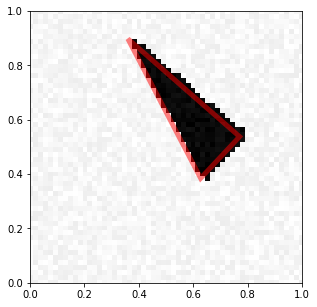

In [311]:
visualize_prediction(X_train[0], Y_train[0])

In [316]:
[X_test, Y_test] = generate_test_set_regression()
X_test = X_test.reshape(X_test.shape[0], 72, 72, 1)
X_test = X_test.astype('float32')
Y_sorted = sort_vertices(Y_test)

In [317]:
model = Sequential()
model.add(Conv2D(16, (5, 5), activation='relu', input_shape=(72, 72, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (2, 2), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(500, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(1000, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(2000, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(6))
model.compile(loss='mean_squared_error', optimizer='adam')
Y_trainsorted = sort_vertices(Y_train)
model.fit(X_train, Y_trainsorted, batch_size=128, epochs=10, verbose=1, 
          validation_split=0.1)

Train on 2970 samples, validate on 330 samples
Epoch 1/10
2970/2970 [==============================] - 19s 6ms/step - loss: 0.0704 - val_loss: 0.0382
Epoch 2/10
2970/2970 [==============================] - 14s 5ms/step - loss: 0.0339 - val_loss: 0.0255
Epoch 3/10
2970/2970 [==============================] - 14s 5ms/step - loss: 0.0248 - val_loss: 0.0196
Epoch 4/10
2970/2970 [==============================] - 14s 5ms/step - loss: 0.0190 - val_loss: 0.0138
Epoch 5/10
2970/2970 [==============================] - 14s 5ms/step - loss: 0.0138 - val_loss: 0.0111
Epoch 6/10
2970/2970 [==============================] - 14s 5ms/step - loss: 0.0110 - val_loss: 0.0102
Epoch 7/10
2970/2970 [==============================] - 14s 5ms/step - loss: 0.0093 - val_loss: 0.0077
Epoch 8/10
2970/2970 [==============================] - 14s 5ms/step - loss: 0.0079 - val_loss: 0.0079
Epoch 9/10
2970/2970 [==============================] - 14s 5ms/step - loss: 0.0071 - val_loss: 0.0070
Epoch 10/10
2970/2970 [===

In [318]:
model.evaluate(X_test, Y_sorted)

300/300 [==============================] - 1s 2ms/step


0.007254566065967083

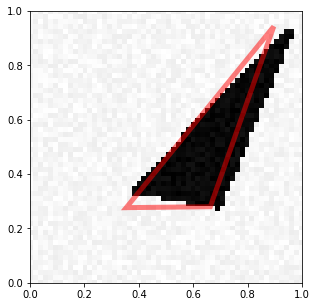

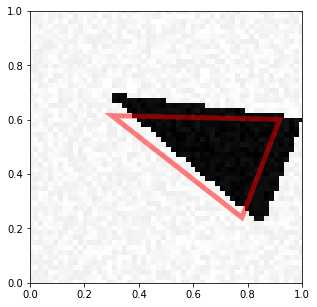

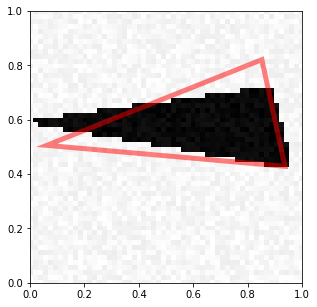

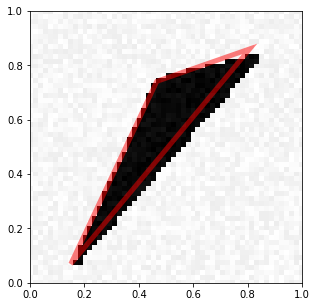

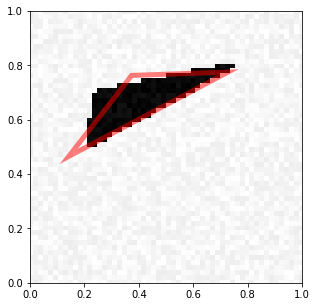

In [327]:
pred = model.predict(X_test)
visualize_prediction(X_test[0], pred[0])
visualize_prediction(X_test[10], pred[10])
visualize_prediction(X_test[30], pred[30])
visualize_prediction(X_test[100], pred[100])
visualize_prediction(X_test[230], pred[230])

## Image Denoising :

In [410]:
[X_train, Y_train] = generate_dataset_denoising(300, 100, True)

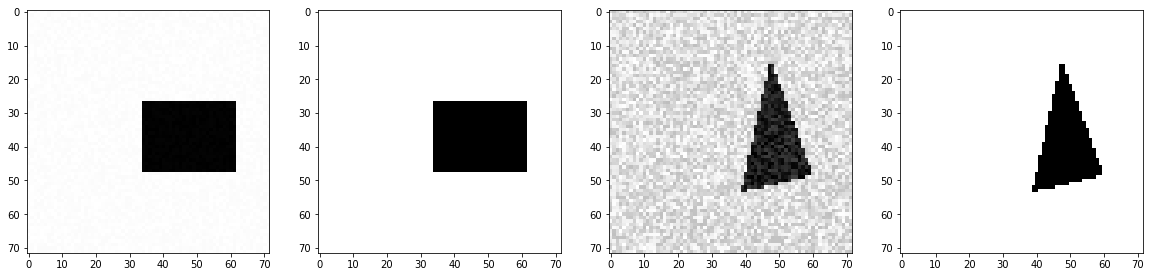

In [411]:
fig, size = plt.subplots(figsize=(20,10),)
plt.subplot(141)
plt.imshow(X_train[0].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
plt.subplot(142)
plt.imshow(Y_train[0].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
plt.subplot(143)
plt.imshow(X_train[1].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
plt.subplot(144)
plt.imshow(Y_train[1].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

In [347]:
X_train = X_train.reshape(X_train.shape[0], 72, 72, 1)
Y_train = Y_train.reshape(X_train.shape[0], 72, 72, 1)

In [419]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(28, 28, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
print('hhhhhhhhh',model.output_shape)
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D(size=(2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D(size = (2,2)))
model.add(Conv2D(1, (3, 3), activation='sigmoid', padding='same'))
print('hhhhhhhhh',model.output_shape)
#Model.compile(loss='mean_squared_error', optimizer='adam')
#Model.fit(X_train, Y_train, batch_size=128, epochs=10, verbose=1, validation_split=0.1)

hhhhhhhhh (None, 6, 6, 32)
hhhhhhhhh (None, 24, 24, 1)


In [425]:
from keras.models import Model
input_img = Input(shape=(72, 72, 1))  # adapt this if using `channels_first` image data format

x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)
autoencoder = Model(input_img, encoded)
print('hhhhhhhhh',autoencoder.output_shape)

hhhhhhhhh (None, 18, 18, 32)


In [328]:
[x, Y]

19800

In [332]:
np.random.random(10)

array([0.71787722, 0.03341363, 0.20296301, 0.92695494, 0.1760138 ,
       0.10998908, 0.61615807, 0.79904709, 0.77862761, 0.27723218])